# 06. Time series data - Version: daily data analysis
## Notebook content:

#### PART 1: Analysing time series data
    1. Importing libraries and data
    2. Subsetting, wrangling, and cleaning time-series data
    3. Time series analysis: decomposition
    4. Testing for stationarity
    5. Stationarizing the data
    
#### PART 2: Time series forecasting
    1. Defining parameters
    2. Splitting data
    3. Running and fitting the model
    4. Iterating

## PART 1: Analysing time series data

### 1. Importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how the plots will appear.

In [2]:
path = r'C:\Users\bruna\Data Analysis Projects\2023-12 Superstore Sales Analysis'

In [3]:
# Import the sales data
sales_clean = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'sales_clean.pkl'))

In [4]:
sales_clean.head()

,Row_ID,Order_ID,Order_Date,Ship_Date,Ship_Mode,Customer_ID,Segment,City,State,Postal_Code,Region,Product_ID,Category,Sub_Category,Product_Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.960,2,0.0,41.9136
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.620,2,0.0,6.8714
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.368,2,0.2,2.5164
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.860,7,0.0,14.1694
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Consumer,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.280,4,0.0,1.9656


In [5]:
sales_clean.shape

(8113, 19)

### 2. Subsetting and smoothing time-series data

In [6]:
# Group by 'Order_Date' and calculate the sum of 'Sales' for each date
sales_per_date = sales_clean.groupby('Order_Date')['Sales'].sum().reset_index()

# Rename columns for clarity
sales_per_date.columns = ['Order_Date', 'Total_Sales']

In [7]:
sales_per_date.head()

,Order_Date,Total_Sales
0,2014-01-03,16.448
1,2014-01-04,15.324
2,2014-01-05,19.536
3,2014-01-06,75.360
4,2014-01-07,10.430


In [8]:
sales_per_date.shape

(1211, 2)

In [9]:
# Smoothing temporal data
#Specify the window size for the moving average
window_size = 7 #one week period

# Apply a simple moving average using the rolling method
smoothed_data = sales_per_date['Total_Sales'].rolling(window=window_size).mean()

# Add the smoothed data as a new column to the DataFrame
sales_per_date['Sales_Smoothed'] = smoothed_data

In [10]:
sales_per_date.head()

,Order_Date,Total_Sales,Sales_Smoothed
0,2014-01-03,16.448,NaN
1,2014-01-04,15.324,NaN
2,2014-01-05,19.536,NaN
3,2014-01-06,75.360,NaN
4,2014-01-07,10.430,NaN


In [11]:
# Check for missing values

sales_per_date.isnull().sum() 

Order_Date        0
Total_Sales       0
Sales_Smoothed    6
dtype: int64

In [12]:
# Remove rows with missing values

sales_per_date = sales_per_date[sales_per_date['Sales_Smoothed'].isnull() == False]

In [13]:
sales_per_date.head()

,Order_Date,Total_Sales,Sales_Smoothed
6,2014-01-10,54.830,33.210286
7,2014-01-11,9.940,32.280571
8,2014-01-13,1035.265,177.986429
9,2014-01-15,149.950,196.617000
10,2014-01-16,299.964,228.703286


In [14]:
# Drop Total_Sales column

sales_per_date = sales_per_date.drop(columns = 'Total_Sales')

In [15]:
sales_per_date.head()

,Order_Date,Sales_Smoothed
6,2014-01-10,33.210286
7,2014-01-11,32.280571
8,2014-01-13,177.986429
9,2014-01-15,196.617000
10,2014-01-16,228.703286


In [16]:
sales_per_date.shape

(1205, 2)

In [17]:
# Check for duplicates

dups = sales_per_date.duplicated()
dups.sum()

#No dups

0

In [18]:
# Set the "Date" column as the index

from datetime import datetime

sales_per_date['datetime'] = pd.to_datetime(sales_per_date['Order_Date']) # Create a datetime column from "Order_Date"
sales_per_date = sales_per_date.set_index('datetime') # Set the datetime as the index of the dataframe.
sales_per_date.drop(['Order_Date'], axis=1, inplace=True) # Drop the "Order_Date" column.
sales_per_date.head()

,Sales_Smoothed
datetime,
2014-01-10,33.210286
2014-01-11,32.280571
2014-01-13,177.986429
2014-01-15,196.617000
2014-01-16,228.703286


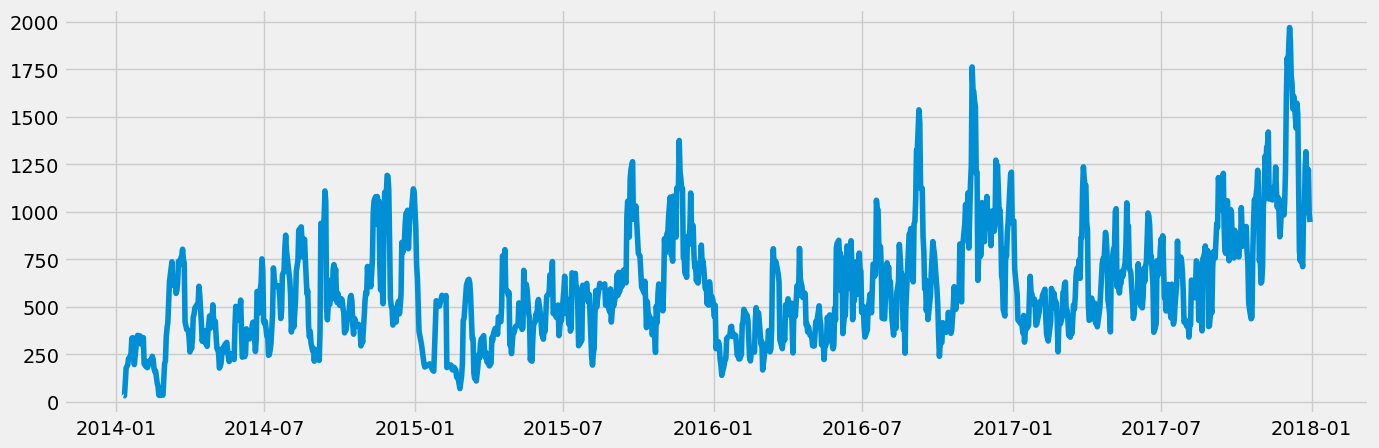

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(sales_per_date)

### 3. Time-series analysis: decomposition

In [20]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(sales_per_date, model='additive', period = 1)

In [21]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

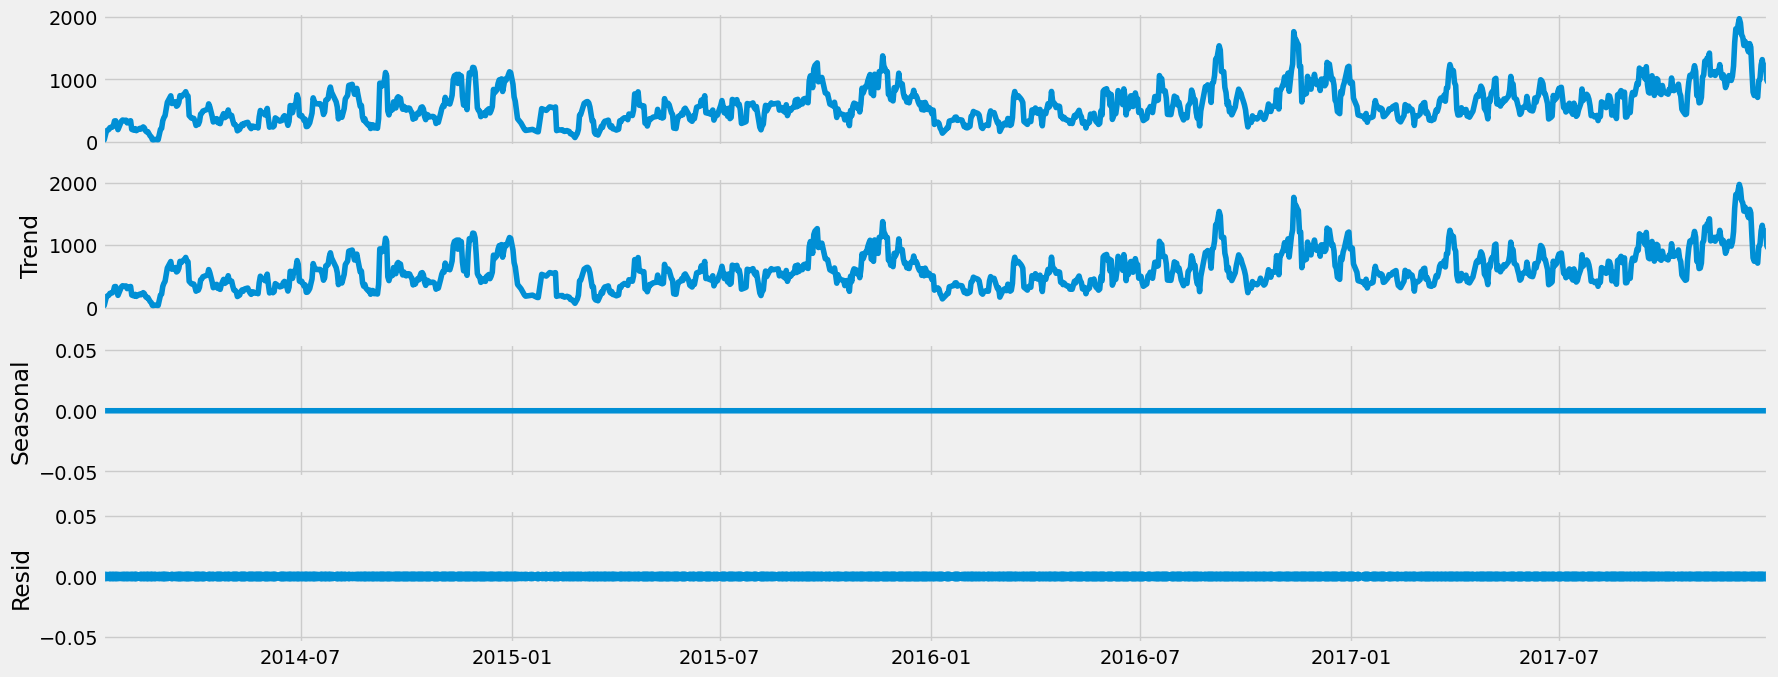

In [22]:
# Plot the separate components

decomposition.plot()
plt.show()

- Conclusions: 
There is no seasonality in the data, and the noise has been removed during Smoothing process.
The data seems to have a slight positive trend, indicating it might notbe starionary. Testing for stationarity is crucial.

### 4. Testing for stationarity

In [23]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why we need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(sales_per_date['Sales_Smoothed'])

Dickey-Fuller Stationarity test:
Test Statistic                   -3.348808
p-value                           0.012833
Number of Lags Used              21.000000
Number of Observations Used    1183.000000
Critical Value (1%)              -3.435890
Critical Value (5%)              -2.863986
Critical Value (10%)             -2.568072
dtype: float64


- Conclusion: 
p-value is <0.05 indicating a significant result. 
Test statistic is smaller than the critical value (5%), which means the null hypothesis can be rejected. There isn't a unit root in the data, indicating the data is stationary. An auto-correlation check is needed to confirm non-stationarity


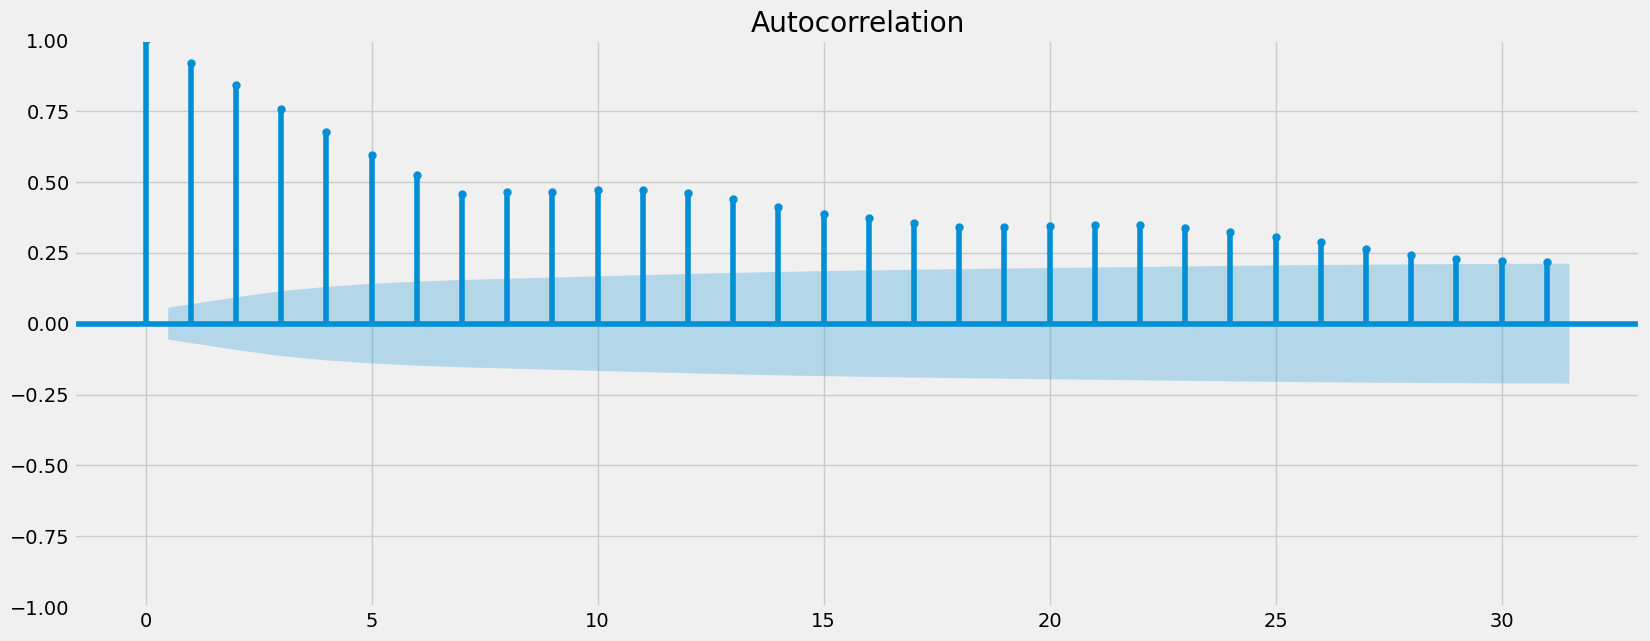

In [24]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(sales_per_date)
plt.show()

- Conclusion: the vertical lines above the confidence interval indicate that the lags are significantly correlated with eachother. This means the data is non-stationary and will need stationarizing.

In [25]:
# Differencing:

data_diff = sales_per_date - sales_per_date.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [26]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [27]:
data_diff.head()

,Sales_Smoothed
datetime,
2014-01-11,-0.929714
2014-01-13,145.705857
2014-01-15,18.630571
2014-01-16,32.086286
2014-01-18,7.776286


In [28]:
data_diff.columns

Index(['Sales_Smoothed'], dtype='object')

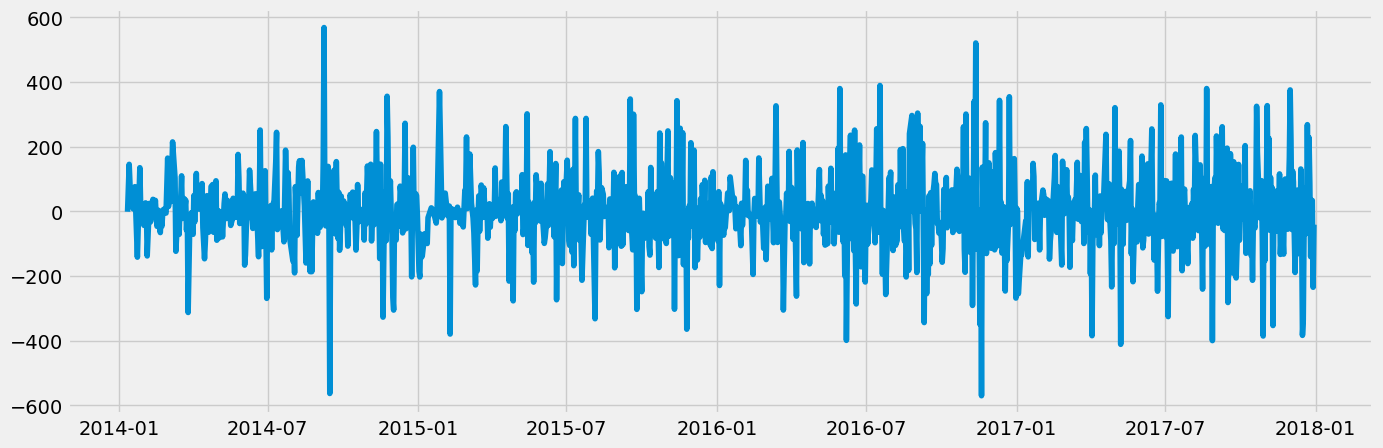

In [29]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [30]:
# Check the impact on the Dickey-fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.144453e+01
p-value                        6.063956e-21
Number of Lags Used            2.000000e+01
Number of Observations Used    1.183000e+03
Critical Value (1%)           -3.435890e+00
Critical Value (5%)           -2.863986e+00
Critical Value (10%)          -2.568072e+00
dtype: float64


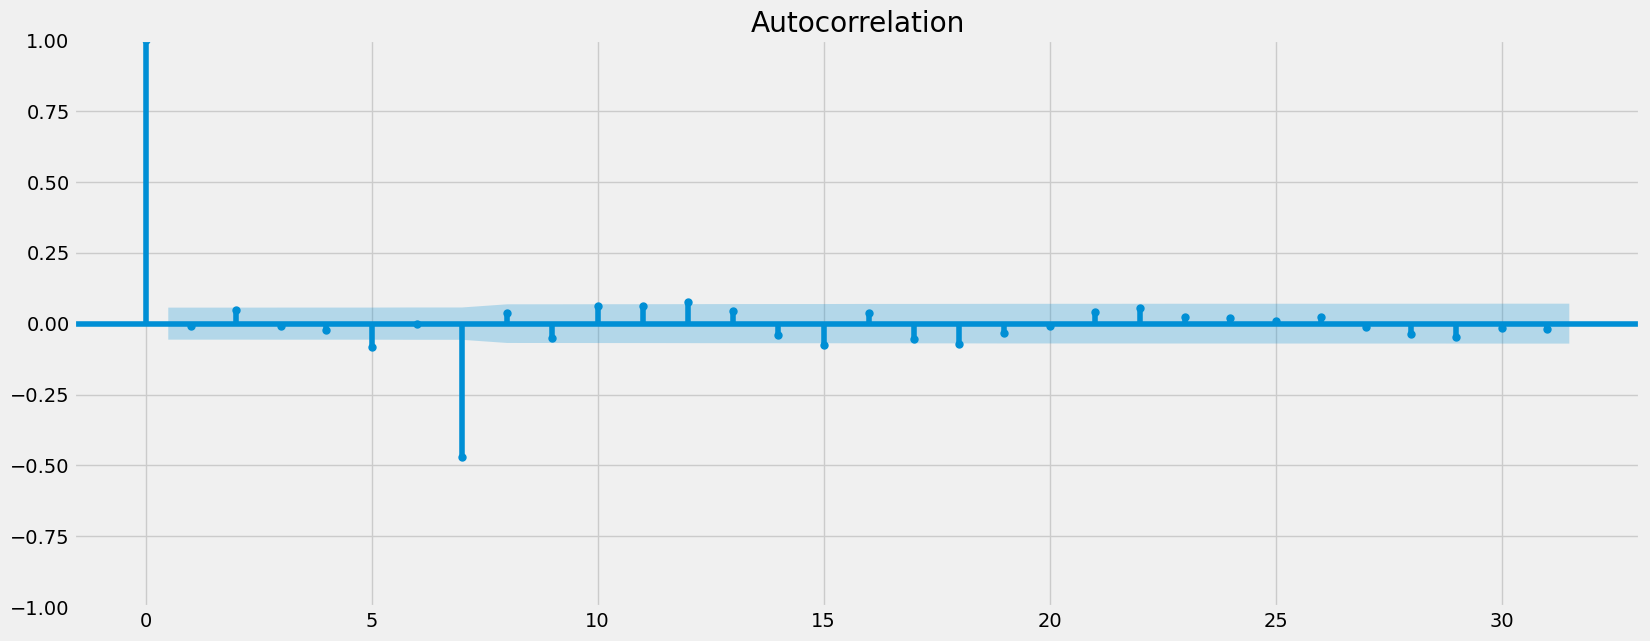

In [31]:
# Check out the plot of autocorrelations after differencing:

plot_acf(data_diff)
plt.show()

## PART 2: Time series forecasting

### 1. Defining Your Parameters

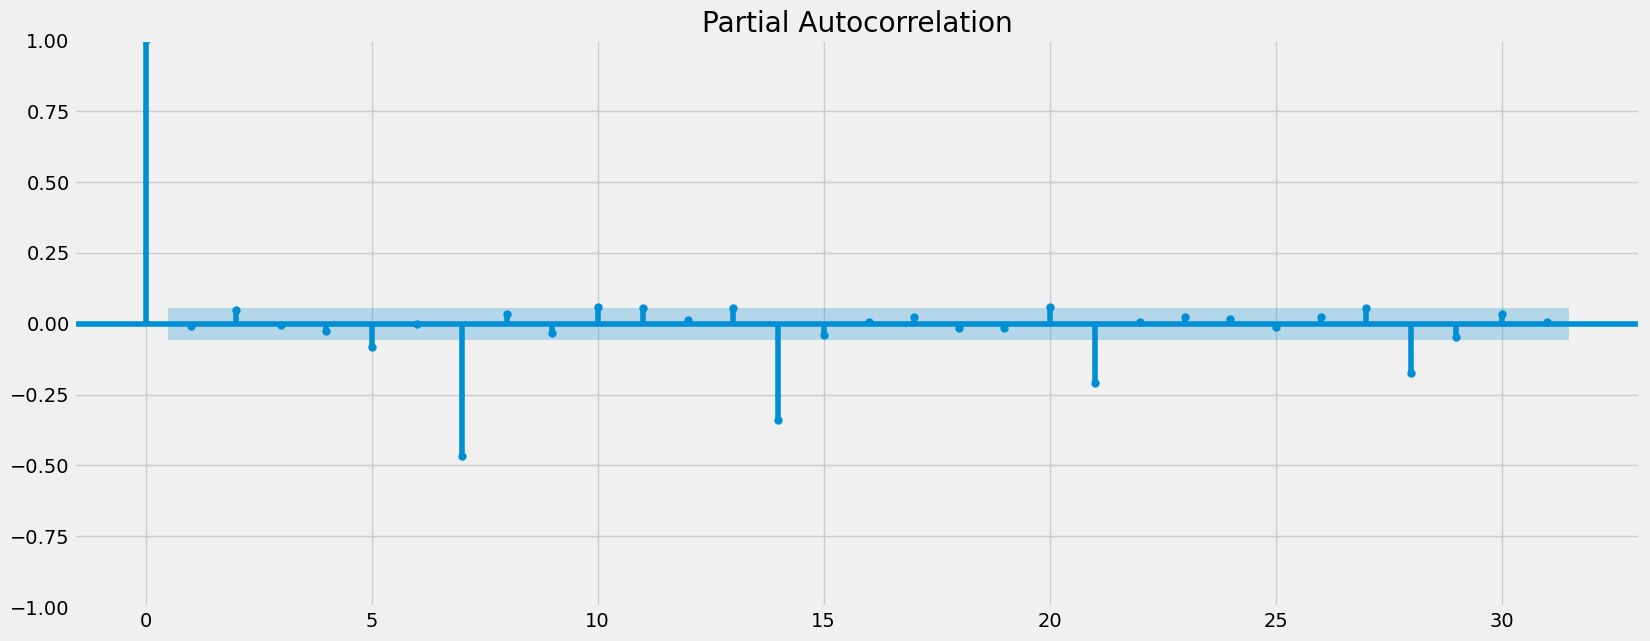

<Figure size 4500x4500 with 0 Axes>

In [33]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

There are some highly positive bars. These indicate significant correlations. Let’s start by picking 5 AR terms to compensate for the highest of the partial autocorrelations. This makes p = 5.

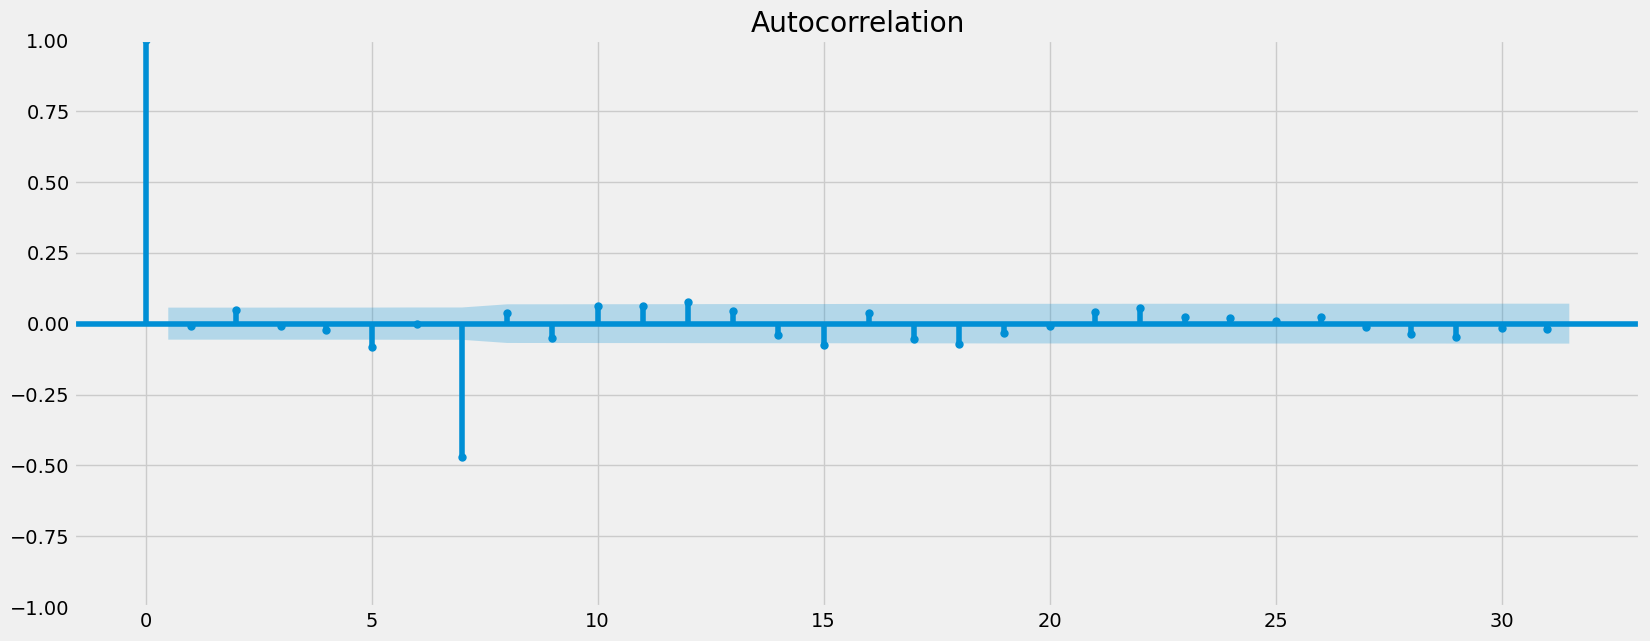

<Figure size 1500x500 with 0 Axes>

In [34]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

q = 2

### 2. Splitting the Data

In [59]:
# Split the data

train = data_diff['Sales_Smoothed'][:886]
test = data_diff['Sales_Smoothed'][885:]

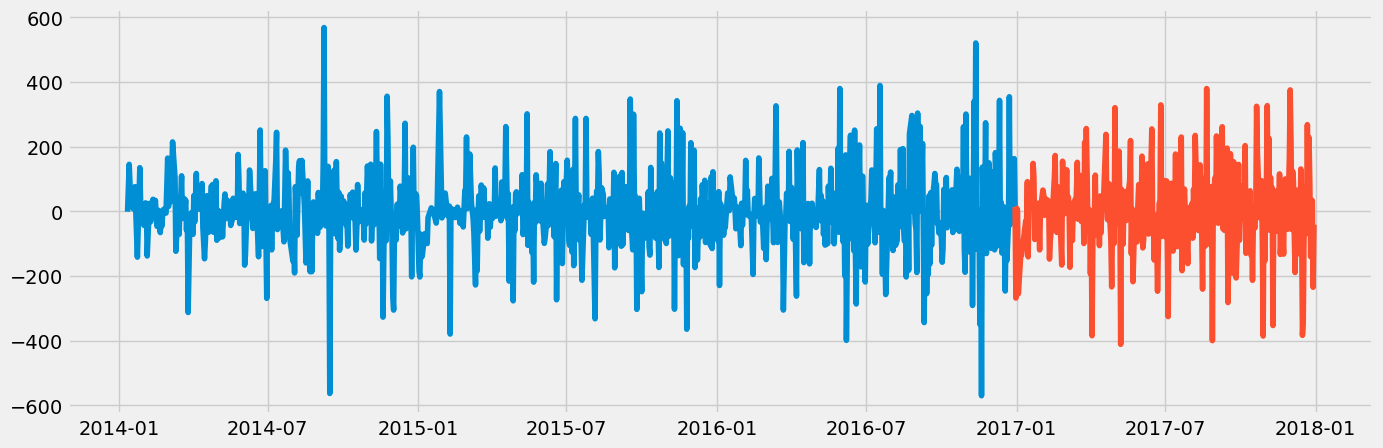

In [60]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [61]:
test.shape

(319,)

### 3. Running and Fitting the Model

In [63]:
from statsmodels.tsa.api import ARIMA # Import the model you need

                               SARIMAX Results                                
Dep. Variable:         Sales_Smoothed   No. Observations:                  886
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -5431.417
Date:                Sun, 21 Jan 2024   AIC                          10880.833
Time:                        16:54:32   BIC                          10923.903
Sample:                             0   HQIC                         10897.300
                                - 886                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1225      0.212     -0.578      0.563      -0.538       0.293
ar.L2          0.9735      0.187      5.212      0.000       0.607       1.340
ar.L3          0.0657      0.050      1.323      0.1

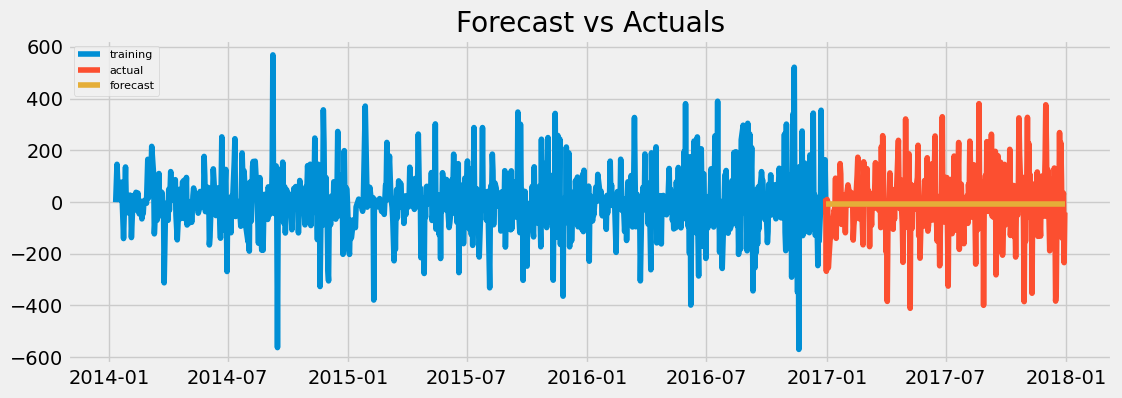

In [76]:
model = ARIMA(train, order=(5, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(3, 319, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 319 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 4. Iterating

                               SARIMAX Results                                
Dep. Variable:         Sales_Smoothed   No. Observations:                  886
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -5455.419
Date:                Sun, 21 Jan 2024   AIC                          10920.838
Time:                        16:55:12   BIC                          10944.766
Sample:                             0   HQIC                         10929.986
                                - 886                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0347      0.037     -0.942      0.346      -0.107       0.038
ar.L2          0.0589      0.033      1.798      0.072      -0.005       0.123
ar.L3          0.0074      0.034      0.217      0.8

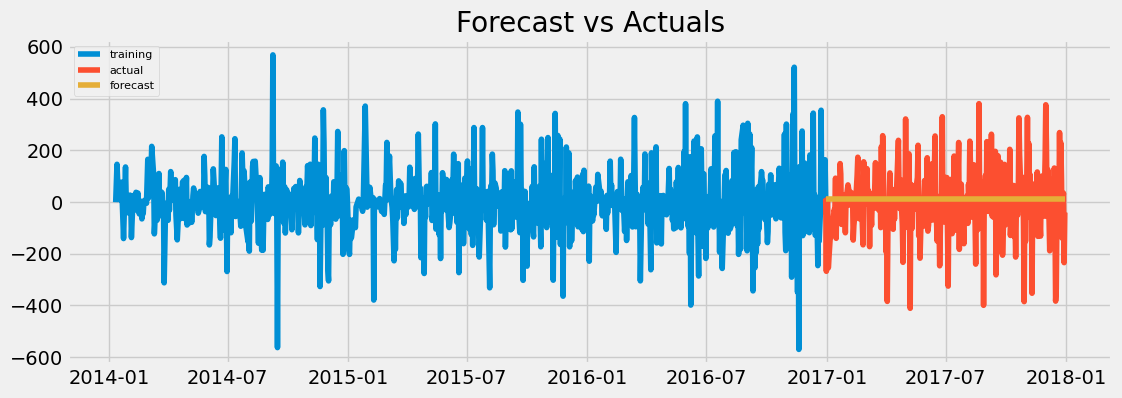

In [80]:
model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, 319, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                               SARIMAX Results                                
Dep. Variable:         Sales_Smoothed   No. Observations:                  886
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -5448.566
Date:                Sun, 21 Jan 2024   AIC                          10905.132
Time:                        16:55:50   BIC                          10924.274
Sample:                             0   HQIC                         10912.450
                                - 886                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9473      0.033    -28.562      0.000      -1.012      -0.882
ma.L1         -0.0981      0.151     -0.649      0.516      -0.394       0.198
ma.L2         -0.9015      0.139     -6.489      0.0

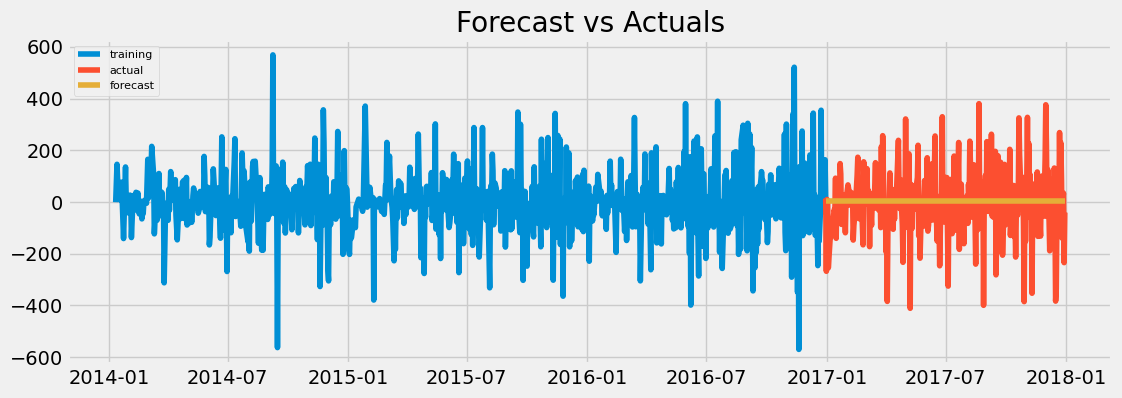

In [83]:
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(3, 319, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()